<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/novel/a_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
import keras

     |████████████████████████████████| 706kB 16.1MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    #img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (550, 413), antialias = True)
    img = img / 255.0
    return img

In [4]:
def load_airlight(img_path):
  air=img_path.split("_")[-1][:-4];
  return air

In [5]:
import cv2
a='drive/MyDrive/kitti/hazy/0000000000_12_0.70802.png'
b=cv2.imread(a)


In [6]:
b.shape

(352, 1216, 3)

In [7]:
def display_img(model, hazy_img, orig_img):
    pred = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], pred[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

In [17]:
def data_path(hazy_img_path,percentage=0.8,seed_val=101):
    
    random.seed(seed_val)
    train_img = []
    val_img = []
    train_air= []
    val_air= []
    
    
    #hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    n = len(hazy_img)
    n1=percentage*n;

    random.shuffle(hazy_img)
    n=n1;
    train_keys = hazy_img[:int(0.9*n)]        #90% data for train, 10% for test
    val_keys = hazy_img[int(0.9*n):int(1.0*n)]
    #hazy_img=hazy_img[:n]
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
        
    
    for img in hazy_img:
        air=img.split("_")[-1][:-4];
  
        try:
          if (split_dict[img] == 'train'):
              train_air.append(float(air))
              train_img.append(img)
          else:
              val_air.append(float(air))
              val_img.append(img)
        except KeyError:
          pass
    return train_img,train_air, val_img,val_air

In [18]:
def dataloader(train_data,train_res, val_data,val_res, batch_size):
    print(len(train_data))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img for img in train_data]).map(lambda x: load_image(x))
    train_data_airlight = tf.data.Dataset.from_tensor_slices([a for a in train_res])
    train = tf.data.Dataset.zip((train_data_haze,train_data_airlight)).shuffle(100).batch(batch_size)

    val_data_haze = tf.data.Dataset.from_tensor_slices([img for img in val_data]).map(lambda x: load_image(x))
    val_data_airlight = tf.data.Dataset.from_tensor_slices([a for a in val_res])
    val = tf.data.Dataset.zip((val_data_haze,val_data_airlight)).shuffle(100).batch(batch_size)

    

    

    return train, val

In [37]:
model=dehaze_net()
model.model().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 412, 548, 16) 1216        input_2[0][0]                    
__________________________________________________________________________________________________
maxout_1 (Maxout)               (None, 412, 548, 4)  0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 412, 548, 16) 592         maxout_1[0][0]                   
____________________________________________________________________________________________

In [34]:
class dehaze_net(tf.keras.Model):
  def __init__(self):
    super(dehaze_net,self).__init__()
    self.conv1 = Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', use_bias = True)
    self.Maxout=tfa.layers.Maxout(num_units=4,axis= -1)
    self.conv2 = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', use_bias = True)
    self.conv3 = Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', use_bias = True)
    self.conv4 = Conv2D(filters = 16, kernel_size = 7, strides = 1, padding = 'same', use_bias = True)
    self.maxpool=MaxPool2D(7,strides=1,padding='same')
    self.conv5 = Conv2D(filters = 1, kernel_size = 6, strides = 1, padding = 'same', use_bias = True)
    self.flatten= tf.keras.layers.Flatten()
    #self.dense1=tf.keras.layers.Dense(100,activation='relu')
    self.dense2=tf.keras.layers.Dense(1,activation='relu')


  def call(self,inputs):
    out = self.conv1(inputs)
    out = self.Maxout(out)
    out1 = self.conv2(out)
    out2 = self.conv3(out)
    out3 = self.conv4(out)
    y=tf.keras.layers.concatenate([out1,out2,out3])
    y = self.maxpool(y)
    y = self.conv5(y)
    #print(y.shape)
    y= ReLU()(y)
    y= self.flatten(y)
    #y=self.dense1(y)
    y=self.dense2(y)
    return y

   #K = conv5
   #output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
   #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
   #output=tf.image.resize(output1, size = (413, 550), antialias = True)
   #model = Model(inputs = x, outputs = output)
   
   #return output

  def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

In [58]:
def build_model(input_shape,training=True):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(8, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    
    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.6,training=training),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.5,training=training),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2,training=training),


    # output layer
    keras.layers.Dense(1, activation='relu')

    return model

In [10]:
class a_net(tf.keras.Model):
  def __init__(self):
    super(a_net,self).__init__()
    self.seq = tf.keras.Sequential()

    # 1st conv layer
    self.seq.add(tf.keras.layers.Conv2D(input_shape=(None, None, 3),filters=32,kernel_size= (3, 3), activation='relu'))
    self.seq.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    self.seq.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    self.seq.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    self.seq.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    self.seq.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    self.seq.add(keras.layers.Conv2D(8, (2, 2), activation='relu'))
    self.seq.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    self.seq.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    self.seq.add(keras.layers.Flatten())
    
    # 1st dense layer
    self.dense1=keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))
    self.drop1=keras.layers.Dropout(0.6)

    # 2nd dense layer
    self.dense2=keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))
    self.drop2=keras.layers.Dropout(0.5)

    # 3rd dense layer
    self.dense3=keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))
    self.drop3=keras.layers.Dropout(0.2)


    # output layer
    self.out=keras.layers.Dense(1, activation='relu')



  def call(self,inputs,train=True):
    x=self.seq(inputs)
    x=self.dense1(x)
    x=self.drop1(x,train)
    x=self.dense2(x)
    x=self.drop2(x,train)
    x=self.dense3(x)
    x=self.drop3(x,train)
    return self.out(x)

   #K = conv5
   #output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
   #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
   #output=tf.image.resize(output1, size = (413, 550), antialias = True)
   #model = Model(inputs = x, outputs = output)
   
   #return output

  def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 412, 548, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None)              6264      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               14205440  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1644

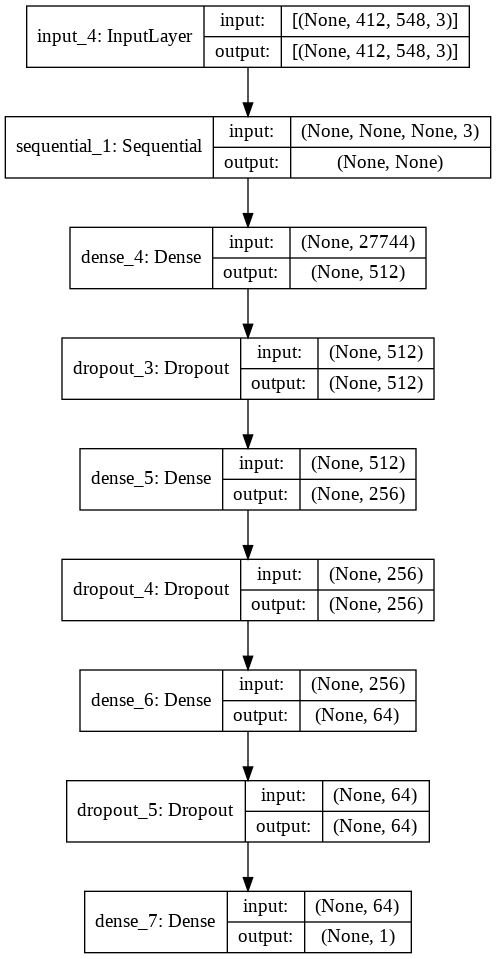

In [12]:
model=a_net()
model.model().summary()

dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

In [54]:
#model=build_model((352,1216,3))

net.summary()
#dot_img_file = '/tmp/model_1.png'
#tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 350, 1214, 18)     504       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 175, 607, 18)      0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 175, 607, 18)      72        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 173, 605, 8)       1304      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 87, 303, 8)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 87, 303, 8)        32        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 86, 302, 4)       

In [27]:
# Hyperparameters
epochs = 2
batch_size = 16
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

train_data,train_res, val_data,val_res = data_path(hazy_img_path = '/content/drive/MyDrive/kitti/hazy')
#train_data,train_res, val_data,val_res = data_path(hazy_img_path = '/content/drive/MyDrive/generated_dataset/hazy/')
#train_data, val_data = data_path()
train, val = dataloader(train_data,train_res, val_data,val_res, batch_size)

optimizer = Adam(learning_rate = 1e-7)
net =a_net()
net.load_weights('/content/drive/MyDrive/nets/prelim_model/a_net/weights/')
#net =dehaze_net()
#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

4320


In [28]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()

        for step, (train_batch_haze, train_res) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #print(train_logits.shape)
                train_res=np.expand_dims(train_res,axis=-1)
                loss = mean_squared_error(train_res, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))
            
            train_loss_tracker.update_state(train_res, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        for step, (val_batch_haze, val_res) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_res=np.expand_dims(val_res,axis=-1)
            #print(val_logits.shape)
            #print("---------------------")
            val_loss_tracker.update_state(val_res, val_logits)
            #if step % 64 ==0:
                #display_img(net, val_batch_haze, val_batch_orig)
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

In [29]:
%%time
train_model(2, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 [=====]  -  Training Loss: 0.6561  -  Validation Loss: 0.6526  -   Time taken: 166.09s

Start of epoch 1 [=====]  -  Training Loss: 0.6606  -  Validation Loss: 0.6500  -   Time taken: 164.70s
CPU times: user 4min 54s, sys: 6.62 s, total: 5min 1s
Wall time: 5min 30s


In [30]:
net.save('/content/drive/MyDrive/nets/prelim_model/a_net/')
net.save_weights('/content/drive/MyDrive/nets/prelim_model/a_net/weights/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/prelim_model/a_net/assets


In [ ]:
%%time
train_model(, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 [===================================================================]  -  Training Loss: 0.5620  -  Validation Loss: 0.3334  -   Time taken: 3731.36s

Start of epoch 1 [===================================================================]  -  Training Loss: 0.3249  -  Validation Loss: 0.3269  -   Time taken: 124.88s

Start of epoch 2 [===================================================================]  -  Training Loss: 0.2400  -  Validation Loss: 0.2279  -   Time taken: 125.40s

Start of epoch 3 [===================================================================]  -  Training Loss: 0.1969  -  Validation Loss: 0.1995  -   Time taken: 125.07s

Start of epoch 4 [===================================================================]  -  Training Loss: 0.1763  -  Validation Loss: 0.2328  -   Time taken: 125.84s

Start of epoch 5 [===================================================================]  -  Training Loss: 0.1590  -  Validation Loss: 0.1845  -   Time taken: 125.5

In [ ]:
net.save_weights('/content/drive/MyDrive/nets/a_net/0.1475')

In [ ]:
optimizer = Adam(learning_rate = 1e-5)

In [ ]:
%%time
train_model(30, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 [===================================================================]  -  Training Loss: 0.0933  -  Validation Loss: 0.1277  -   Time taken: 125.42s

Start of epoch 1 [===================================================================]  -  Training Loss: 0.0892  -  Validation Loss: 0.1247  -   Time taken: 125.59s

Start of epoch 2 [===================================================================]  -  Training Loss: 0.0871  -  Validation Loss: 0.1238  -   Time taken: 126.30s

Start of epoch 3 [===================================================================]  -  Training Loss: 0.0864  -  Validation Loss: 0.1233  -   Time taken: 126.45s

Start of epoch 4 [===================================================================]  -  Training Loss: 0.0866  -  Validation Loss: 0.1206  -   Time taken: 127.63s

Start of epoch 5 [===================================================================]  -  Training Loss: 0.0841  -  Validation Loss: 0.1194  -   Time taken: 128.01

In [ ]:
net.save('/content/drive/MyDrive/nets/a_net/0.1122')
net.save_weights('/content/drive/MyDrive/nets/a_net/0.1122')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/a_net/0.1122/assets


In [ ]:
optimizer = Adam(learning_rate = 1e-6)

In [ ]:
%%time
train_model(2, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 [===================================================================]  -  Training Loss: 0.0713  -  Validation Loss: 0.1107  -   Time taken: 128.81s

Start of epoch 1 [===================================================================]  -  Training Loss: 0.0717  -  Validation Loss: 0.1108  -   Time taken: 128.06s
CPU times: user 3min 49s, sys: 6.29 s, total: 3min 56s
Wall time: 4min 16s


In [ ]:
optimizer = Adam(learning_rate = 1e-7)

In [ ]:
%%time
train_model(5, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 [===================================================================]  -  Training Loss: 0.0708  -  Validation Loss: 0.1108  -   Time taken: 127.23s

Start of epoch 1 [===================================================================]  -  Training Loss: 0.0713  -  Validation Loss: 0.1107  -   Time taken: 126.73s

Start of epoch 2 [===================================================================]  -  Training Loss: 0.0716  -  Validation Loss: 0.1106  -   Time taken: 127.25s

Start of epoch 3 [===================================================================]  -  Training Loss: 0.0706  -  Validation Loss: 0.1108  -   Time taken: 126.53s

Start of epoch 4 [===================================================================]  -  Training Loss: 0.0714  -  Validation Loss: 0.1110  -   Time taken: 127.11s
CPU times: user 9min 28s, sys: 15.2 s, total: 9min 43s
Wall time: 10min 34s


In [ ]:
net.save('/content/drive/MyDrive/nets/a_net/0.1110')
net.save_weights('/content/drive/MyDrive/nets/a_net/0.1110')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/a_net/0.1110/assets
